# Overview in General
<br>  

This file contains a general overview of the data in the graph including node labels and relationships types.

### References
- [jqassistant](https://jqassistant.org)
- [Neo4j Python Driver](https://neo4j.com/docs/api/python-driver/current)

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plot
from neo4j import GraphDatabase

In [2]:
# Please set the environment variable "NEO4J_INITIAL_PASSWORD" in your shell 
# before starting jupyter notebook to provide the password for the user "neo4j". 
# It is not recommended to hardcode the password into jupyter notebook for security reasons.

driver = GraphDatabase.driver(uri="bolt://localhost:7687", auth=("neo4j", os.environ.get("NEO4J_INITIAL_PASSWORD")))
driver.verify_connectivity()

In [3]:
def get_cypher_query_from_file(filename):
    with open(filename) as file:
        return ' '.join(file.readlines())

In [4]:
def query_cypher_to_data_frame(filename : str, limit: int = 10_000):
    cypher_query_template = "{query}\nLIMIT {row_limit}"
    cypher_query = get_cypher_query_from_file(filename)
    cypher_query = cypher_query_template.format(query = cypher_query, row_limit = limit)
    records, summary, keys = driver.execute_query(cypher_query)
    return pd.DataFrame([r.values() for r in records], columns=keys)

In [5]:
def group_to_others_below_threshold(data_frame : pd.DataFrame, value_column : str, name_column: str, threshold: float) -> pd.DataFrame:    
    """
    Adds a new percentage column for the value column and 
    groups all values below the given threshold to "others" in the name column.

    Parameters:
    - data_frame (pd.DataFrame): Input pandas DataFrame
    - value_column (str): Name of the column that contains the numeric value
    - name_column (str): Name of the column that contains the group name that will be replaced by "others" for small values
    - threshold (float): Threshold in % that is used to group values below it into the "others" group

    Returns:
    int:Returning value

    """
    result_data_frame = data_frame[[name_column, value_column]].copy();

    percent_column_name = value_column + 'Percent';

    # Add column with the name given in "percent_column_name" with the percentage of the value column.
    result_data_frame[percent_column_name] = result_data_frame[value_column] / result_data_frame[value_column].sum() * 100.0;

    # Convert name column to string values if it wasn't of that type before
    result_data_frame[name_column] = result_data_frame[name_column].astype(str)

    # Change the group name to "others" if it is called less than the specified threshold
    result_data_frame.loc[result_data_frame[percent_column_name] < threshold, name_column] = 'others';

    # Group by name column (foremost the new "others" entries) and sum their percentage
    #result_data_frame = result_data_frame.groupby(name_column)[percent_column_name].sum();
    result_data_frame = result_data_frame.groupby(name_column).sum();
    # Sort by values descending
    #return result_data_frame.sort_values(ascending=False).to_frame();
    return result_data_frame.sort_values(by=percent_column_name, ascending=False);

In [6]:
def explode_index_value(input: pd.DataFrame, index_value_to_emphasize: str = 'others', base_value: float = 0.02, emphasize_value: float = 0.2):
    """
    "Explode" offsets slices in a pie chart plot by a given value.
    The specified index value will be emphasized with a larger value to make it stand out in the pie chart plot.

    Parameters:
    - input (pd.DataFrame): Input pandas DataFrame with the data that will be plot. (Required)
    - index_value_to_emphasize (str): Value of the index that will be emphasized. (Default= 'others')
    - base_value (float): Base value for all pies in the chart. (Default=0.02)
    - emphasize_value (float): Value for the emphasized pie in the chart. (Default=0.2)

    Returns:
    Array with the same size as the number of rows/pies to plot containing the "explode" value for each of them

    """
    # Each entry in the list corresponds to an x value
    # The comparison with the index_value_to_emphasize produces an array of booleans where nth entry with the emphasized value is "true"
    # Multiplying it leads to 1 for True and 0 for False therefore "exploding" the emphasized entry whilst 
    return (input.index == index_value_to_emphasize) * emphasize_value + base_value     

In [7]:
def plot_pie_chart(input_data_frame: pd.DataFrame, title: str):
    if input_data_frame.empty:
        print("No data to plot for title '" + title + "'.")
        return

    plot.figure();
    
    name_of_the_first_column_containing_the_values=input_data_frame.columns[0]
    total_sum = input_data_frame[name_of_the_first_column_containing_the_values].sum()
    
    def custom_auto_percentage_format(percentage):
        return '{:1.2f}% ({:.0f})'.format(percentage, total_sum * percentage / 100.0)

    axis = input_data_frame.plot(
        kind='pie',
        y=name_of_the_first_column_containing_the_values + 'Percent',
        ylabel='',
        legend=True,
        labeldistance=None,
        autopct=custom_auto_percentage_format,
        textprops={'fontsize': 6},
        pctdistance=1.15,
        cmap=main_color_map,
        figsize=(9,9),
        explode=explode_index_value(input_data_frame, index_value_to_emphasize='others')
    )
    plot.title(title, pad=15)
    axis.legend(bbox_to_anchor=(1.08, 1), loc='upper left')
    plot.show()

In [8]:
#The following cell uses the build-in %html "magic" to override the CSS style for tables to a much smaller size.
#This is especially needed for PDF export of tables with multiple columns.

In [9]:
%%html
<style>
/* CSS style for smaller dataframe tables. */
.dataframe th {
    font-size: 8px;
}
.dataframe td {
    font-size: 8px;
}
</style>

In [10]:
# Main Colormap
main_color_map = 'nipy_spectral'

## Node Labels

### Table 1a - Highest node count by label combination

Lists the 30 label combinations with the highest number of nodes. The labels with the lowest node count are listed in table 1b.
The total list would sum up to the total number of labels (100%).

The whole table can be found in the CSV report `Node_label_combination_count`.

In [11]:
node_count_by_label_combination = query_cypher_to_data_frame("../cypher/Overview/Node_label_combination_count.cypher")
node_count_by_label_combination.head(30)

,nodeLabels,nodesWithThatLabels,nodesWithThatLabelsPercent
0,"[Git, Change]",75118,77.844100
1,"[Git, Commit]",10031,10.395034
2,"[File, Git]",5150,5.336898
3,"[Author, Git, Person]",1183,1.225932
4,"[Git, Tag]",1086,1.125412
5,"[Json, Key]",668,0.692242
6,"[Json, Value, Scalar]",603,0.624883
7,"[Committer, Git, Person]",371,0.384464
8,"[NPM, Dependency]",330,0.341976
9,"[Type, TS, Primitive, ExternalType]",285,0.295343


### Chart 1a - Highest node count by label combination

Values under 0.5% will be grouped into "others" to get a cleaner plot. The group "others" is then broken down in Chart 1b.

<Figure size 640x480 with 0 Axes>

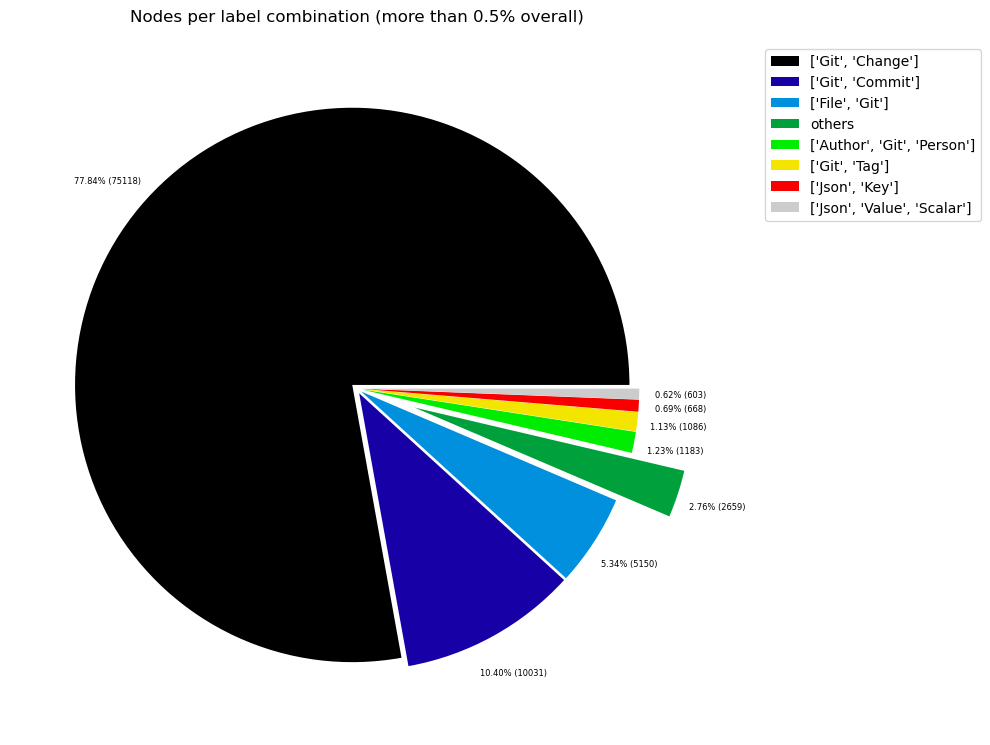

In [12]:
node_count_by_label_combination_significant = group_to_others_below_threshold(
    data_frame=node_count_by_label_combination,
    value_column='nodesWithThatLabels',
    name_column='nodeLabels',
    threshold= 0.5
);
plot_pie_chart(
    input_data_frame=node_count_by_label_combination_significant,
    title='Nodes per label combination (more than 0.5% overall)'
)

### Table 1b - Lowest node count by label combination

Lists the 30 label combinations with the lowest number of nodes until they reach 0.5% of the total node count, which are shown above.

In [13]:
node_count_by_label_combination_lowest_first=node_count_by_label_combination.sort_values(by='nodesWithThatLabels', ascending=True)
node_count_by_label_combination_lowest_first=node_count_by_label_combination_lowest_first.query("`nodesWithThatLabelsPercent` <= 0.50")

node_count_by_label_combination_lowest_first = node_count_by_label_combination_lowest_first.reset_index(drop=True)
node_count_by_label_combination_lowest_first.head(30)

,nodeLabels,nodesWithThatLabels,nodesWithThatLabelsPercent
0,"[Analyze, Task, jQAssistant]",1,0.001036
1,"[File, TS, Scan]",1,0.001036
2,"[TS, Method]",1,0.001036
3,"[Value, TS, ObjectMember]",1,0.001036
4,"[TS, Constructor]",1,0.001036
5,"[TS, Class]",1,0.001036
6,"[TS, Enum]",2,0.002073
7,"[Value, Object, TS]",3,0.003109
8,"[Type, TS, Tuple, ExternalType]",3,0.003109
9,"[Value, TS, Function]",4,0.004145


### Chart 1b - Lowest node count by label combination

Shows the lowest (less than 0.5% overall) node count label combinations. Therefore, this plot breaks down the "others" slice of the pie chart above. Values under 0.01% will be grouped into "others" to get a cleaner plot.

<Figure size 640x480 with 0 Axes>

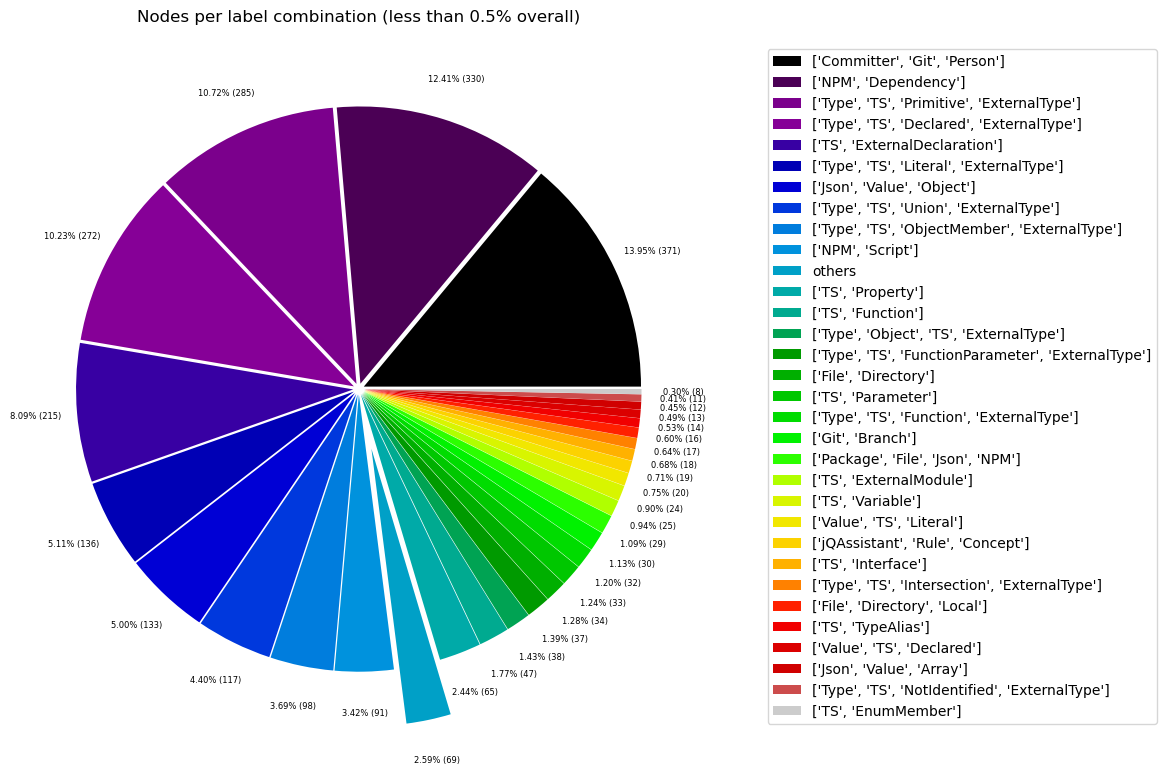

In [14]:

node_count_by_label_combination_lowest_first_significant = group_to_others_below_threshold(
    data_frame=node_count_by_label_combination_lowest_first,
    value_column='nodesWithThatLabels',
    name_column='nodeLabels',
    threshold= 0.3
);
plot_pie_chart(
    input_data_frame=node_count_by_label_combination_lowest_first_significant,
    title='Nodes per label combination (less than 0.5% overall)'
)

### Table 1c - Highest node count by single label

Lists the 40 labels with the highest number of nodes.
Doesn't sum up to the total number of nodes or 100% because one node can have multiple labels.
Helps to identify commonly used labels.

In [15]:
node_count_by_every_label = query_cypher_to_data_frame("../cypher/Overview/Node_label_count.cypher")
node_count_by_every_label.head(40)

,nodeLabel,nodesWithThatLabel,nodesWithThatLabelPercent
0,Git,92969,96.342929
1,Change,75118,77.844100
2,Commit,10031,10.395034
3,File,5242,5.432237
4,TS,1581,1.638376
5,Person,1554,1.610396
6,Json,1445,1.497440
7,Author,1183,1.225932
8,Tag,1086,1.125412
9,ExternalType,1052,1.090178


### Chart 1c - Highest node count by label

Shows the 40 labels with the highest number of nodes.

<Figure size 640x480 with 0 Axes>

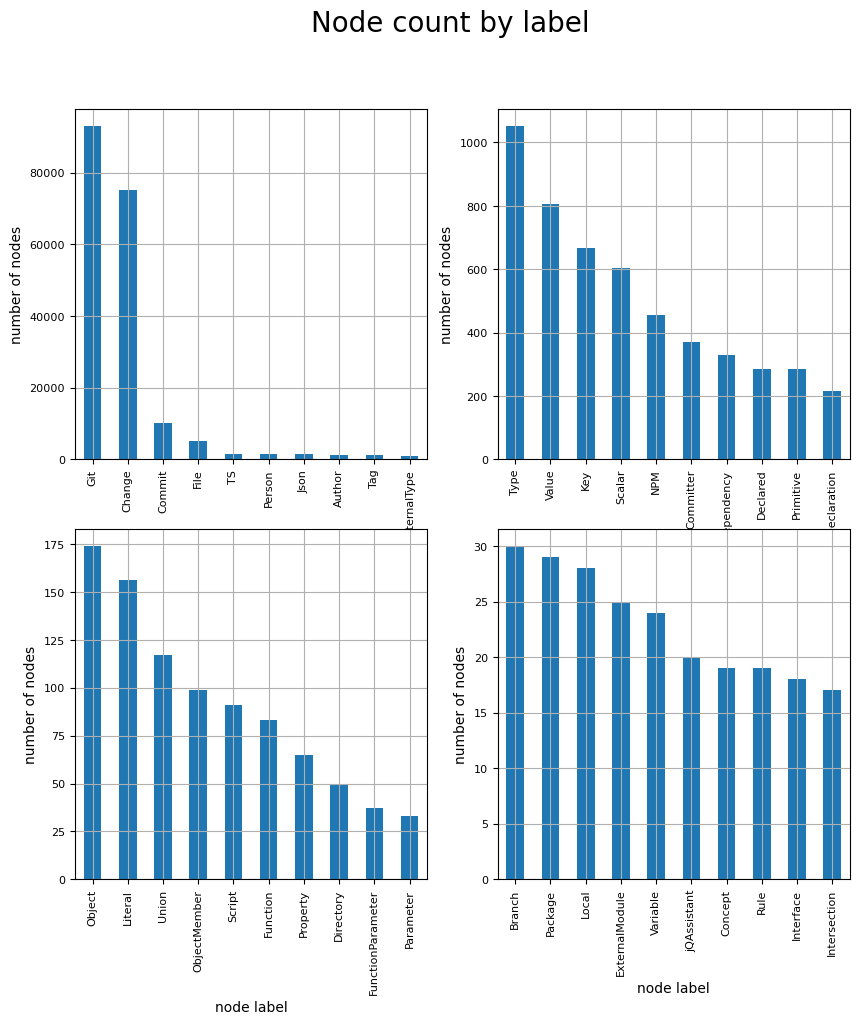

In [16]:
if node_count_by_every_label.empty:
    print("No data to plot")
else:
    plot.figure();
    fig, axes = plot.subplots(nrows=2, ncols=2)
    
    fig.suptitle('Node count by label', fontsize=20)

    node_count_by_every_label.head(10).plot(
        ax=axes[0, 0],
        kind='bar', 
        grid=True,
        x='nodeLabel',
        y='nodesWithThatLabel',
        xlabel='node label',
        ylabel='number of nodes',
        figsize=(10,10),
        legend=False,
        fontsize=8
    )
    node_count_by_every_label.head(20).tail(10).plot(
        ax=axes[0, 1],
        kind='bar', 
        grid=True,
        x='nodeLabel',
        y='nodesWithThatLabel',
        xlabel='node label',
        ylabel='number of nodes',
        figsize=(10,10),
        legend=False,
        fontsize=8
    )
    node_count_by_every_label.head(30).tail(10).plot(
        ax=axes[1,0],
        kind='bar', 
        grid=True,
        x='nodeLabel',
        y='nodesWithThatLabel',
        xlabel='node label',
        ylabel='number of nodes',
        figsize=(10,10),
        legend=False,
        fontsize=8
    )
    node_count_by_every_label.head(40).tail(10).plot(
        ax=axes[1,1],
        kind='bar', 
        grid=True,
        x='nodeLabel',
        y='nodesWithThatLabel',
        xlabel='node label',
        ylabel='number of nodes',
        figsize=(10,10),
        legend=False,
        fontsize=8
    )
    plot.show()

## Relationship Types

### Table 2a - Highest relationship count by type

Lists the 30 relationship types with the highest number of occurrences.
The whole table can be found in the CSV report `Relationship_type_count`.

In [17]:
relationship_count_by_type = query_cypher_to_data_frame("../cypher/Overview/Relationship_type_count.cypher")
total_number_of_relationships = relationship_count_by_type['nodesWithThatRelationshipType'].sum()
print("Total number of relationships:", total_number_of_relationships)
relationship_count_by_type.head(30)

Total number of relationships: 269718


,relationshipType,nodesWithThatRelationshipType,nodesWithThatRelationshipTypePercent
0,CONTAINS_CHANGE,75118,27.850570
1,MODIFIES,75118,27.850570
2,UPDATES,49402,18.316167
3,COMMITTED,20062,7.438139
4,CREATES,17984,6.667705
5,HAS_PARENT,11045,4.095018
6,DELETES,10507,3.895550
7,RENAMES,2775,1.028852
8,HAS_NEW_NAME,1571,0.582460
9,ON_COMMIT,1086,0.402643


### Chart 2a - Highest relationship count by type

Values under 0.5% will be grouped into "others" to get a cleaner plot. The group "others" is then broken down in the second chart.

<Figure size 640x480 with 0 Axes>

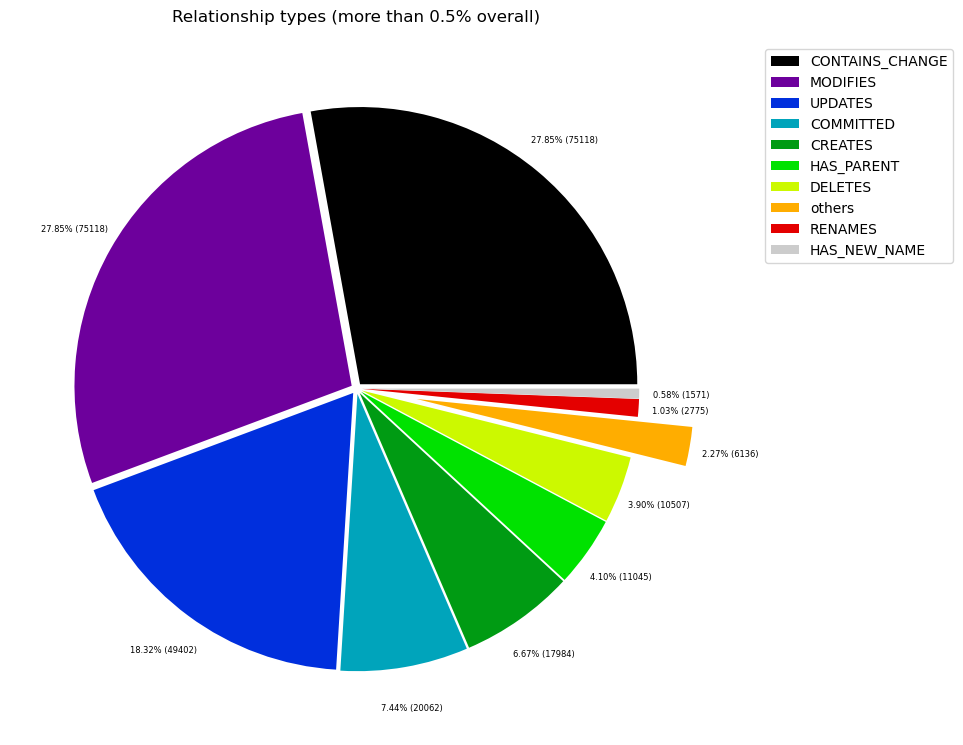

In [18]:
relationship_count_by_type_significant = group_to_others_below_threshold(
    data_frame=relationship_count_by_type,
    value_column='nodesWithThatRelationshipType',
    name_column='relationshipType',
    threshold= 0.5
);
plot_pie_chart(
    input_data_frame=relationship_count_by_type_significant,
    title='Relationship types (more than 0.5% overall)'
)

### Table 2b - Lowest relationship count by type

Lists the 30 relationships type with the lowest number of occurrences up to 0.5% of the total node count. This is essentially breaking down the "others" slice from the chart above.

In [19]:
relationship_count_by_type_lowest_first=relationship_count_by_type.sort_values(by='nodesWithThatRelationshipType', ascending=True)
relationship_count_by_type_lowest_first=relationship_count_by_type_lowest_first.query("`nodesWithThatRelationshipTypePercent` <= 0.50")

relationship_count_by_type_lowest_first = relationship_count_by_type_lowest_first.reset_index(drop=True)
relationship_count_by_type_lowest_first.head(30)

,relationshipType,nodesWithThatRelationshipType,nodesWithThatRelationshipTypePercent
0,CONSTRAINED_BY,4,0.001483
1,REFERENCED_PROJECTS,5,0.001854
2,MEMBER,6,0.002225
3,HAS_ROOT,6,0.002225
4,HAS_NPM_PACKAGE,6,0.002225
5,HAS_CONFIG,6,0.002225
6,HAS_ARGUMENT,6,0.002225
7,DECLARES_ENGINE,6,0.002225
8,CONTAINS_PROJECT,6,0.002225
9,CALLS,6,0.002225


### Chart 2b - Lowest relationship count by type

Shows the lowest (less than 0.5% overall) relationship types. This plot breaks down the "others" slice of the pie chart above. Values under 0.01% will be grouped into "others" to get a cleaner plot.

<Figure size 640x480 with 0 Axes>

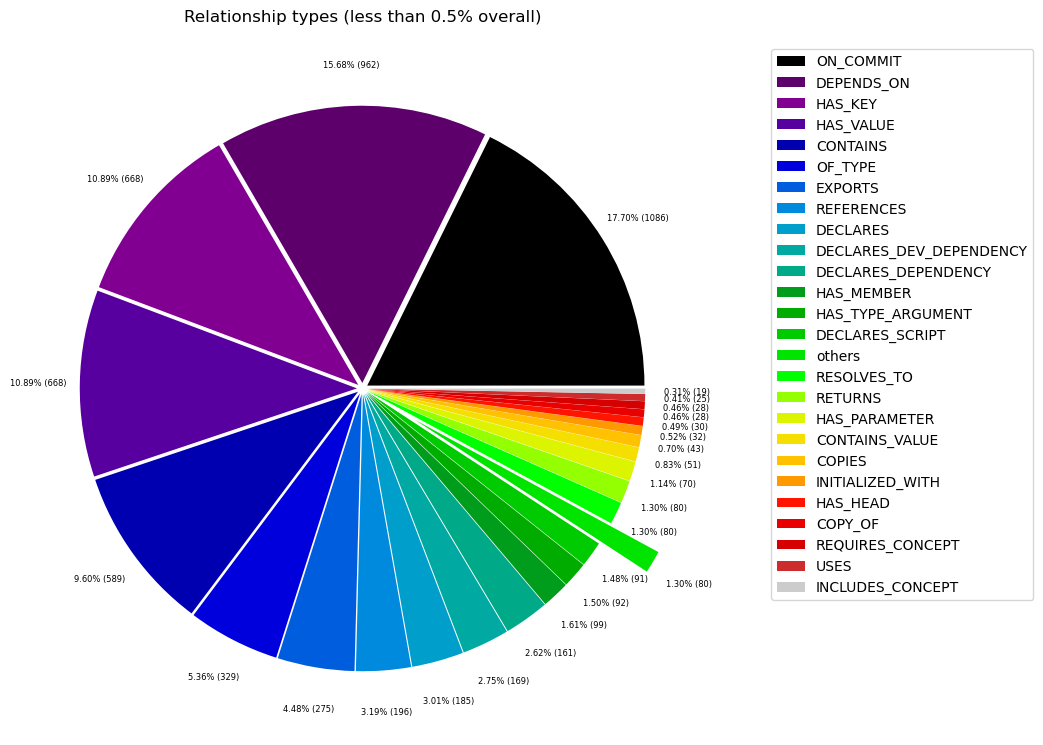

In [20]:
relationship_count_by_type_lowest_first_significant = group_to_others_below_threshold(
    data_frame=relationship_count_by_type_lowest_first,
    value_column='nodesWithThatRelationshipType',
    name_column='relationshipType',
    threshold= 0.3
);
plot_pie_chart(
    input_data_frame=relationship_count_by_type_lowest_first_significant,
    title='Relationship types (less than 0.5% overall)'
)

## Node labels with their relationships

### Table 3a - Highest relationship count by node labels and relationship type

Lists the 30 node labels and their relationship types with the highest number of occurrences.

In [21]:
query_cypher_to_data_frame("../cypher/Overview/Node_labels_and_their_relationships.cypher", limit=30)


,sourceLabels,relationType,targetLabels,numberOfRelationships,numberOfNodesWithSameLabelsAsSource,numberOfNodesWithSameLabelsAsTarget,densityInPercent
0,"[Git, Commit]",CONTAINS_CHANGE,"[Git, Change]",75118,10031,75118,0.009969
1,"[Git, Change]",MODIFIES,"[File, Git]",75118,75118,5150,0.019417
2,"[Git, Change]",UPDATES,"[File, Git]",49402,75118,5150,0.012770
3,"[Git, Change]",CREATES,"[File, Git]",17984,75118,5150,0.004649
4,"[Git, Commit]",HAS_PARENT,"[Git, Commit]",11045,10031,10031,0.010977
5,"[Git, Change]",DELETES,"[File, Git]",10507,75118,5150,0.002716
6,"[Author, Git, Person]",COMMITTED,"[Git, Commit]",10031,1183,10031,0.084531
7,"[Committer, Git, Person]",COMMITTED,"[Git, Commit]",10031,371,10031,0.269542
8,"[Git, Change]",RENAMES,"[File, Git]",2775,75118,5150,0.000717
9,"[File, Git]",HAS_NEW_NAME,"[File, Git]",1571,5150,5150,0.005923


## Graph Density

In [22]:
total_number_of_nodes = node_count_by_label_combination['nodesWithThatLabels'].sum()

print("total_number_of_nodes (vertices):", total_number_of_nodes)
print("total_number_of_relationships (edges):", total_number_of_relationships)

total_directed_graph_density=total_number_of_relationships / (total_number_of_nodes * (total_number_of_nodes - 1))
print("-> total directed graph density:", total_directed_graph_density)
print("-> total directed graph density in percent:", total_directed_graph_density * 100)

total_number_of_nodes (vertices): 96498
total_number_of_relationships (edges): 269718
-> total directed graph density: 2.8965285035972846e-05
-> total directed graph density in percent: 0.0028965285035972847
